In [21]:
import pickle
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, GaussianDropout, AveragePooling2D, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, PReLU, ELU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Activation

# Load the dictionary from the pickle file
with open('entrenamiento.p', 'rb') as file:
    loaded_data = pickle.load(file)


print(loaded_data["coords"].shape)
print(loaded_data["labels"].shape)
print(loaded_data["sizes"].shape)
print(loaded_data["features"].shape)
classes = len(np.unique(loaded_data["labels"]))
unique, counts = np.unique(loaded_data["labels"], return_counts=True)
coefficients = np.array([0.299, 0.587, 0.114])
grayscale_image_array = np.dot(loaded_data["features"], coefficients).astype(np.uint8)
grayscale_image_array = grayscale_image_array.astype(np.float64)
class_frequencies = Counter(loaded_data["labels"].flatten())  
for x in class_frequencies:
    print("Clase: " + str(x) + ". Frecuencia: " + str(class_frequencies[x]))



(34799, 4)
(34799,)
(34799, 2)
(34799, 32, 32, 3)
Clase: 41. Frecuencia: 210
Clase: 31. Frecuencia: 690
Clase: 36. Frecuencia: 330
Clase: 26. Frecuencia: 540
Clase: 23. Frecuencia: 450
Clase: 1. Frecuencia: 1980
Clase: 40. Frecuencia: 300
Clase: 22. Frecuencia: 330
Clase: 37. Frecuencia: 180
Clase: 16. Frecuencia: 360
Clase: 3. Frecuencia: 1260
Clase: 19. Frecuencia: 180
Clase: 4. Frecuencia: 1770
Clase: 11. Frecuencia: 1170
Clase: 42. Frecuencia: 210
Clase: 0. Frecuencia: 180
Clase: 32. Frecuencia: 210
Clase: 27. Frecuencia: 210
Clase: 29. Frecuencia: 240
Clase: 24. Frecuencia: 240
Clase: 9. Frecuencia: 1320
Clase: 5. Frecuencia: 1650
Clase: 38. Frecuencia: 1860
Clase: 8. Frecuencia: 1260
Clase: 10. Frecuencia: 1800
Clase: 35. Frecuencia: 1080
Clase: 34. Frecuencia: 360
Clase: 18. Frecuencia: 1080
Clase: 6. Frecuencia: 360
Clase: 13. Frecuencia: 1920
Clase: 7. Frecuencia: 1290
Clase: 30. Frecuencia: 390
Clase: 39. Frecuencia: 270
Clase: 21. Frecuencia: 270
Clase: 20. Frecuencia: 300
C

Text(0.5, 1.0, 'Class Distribution')

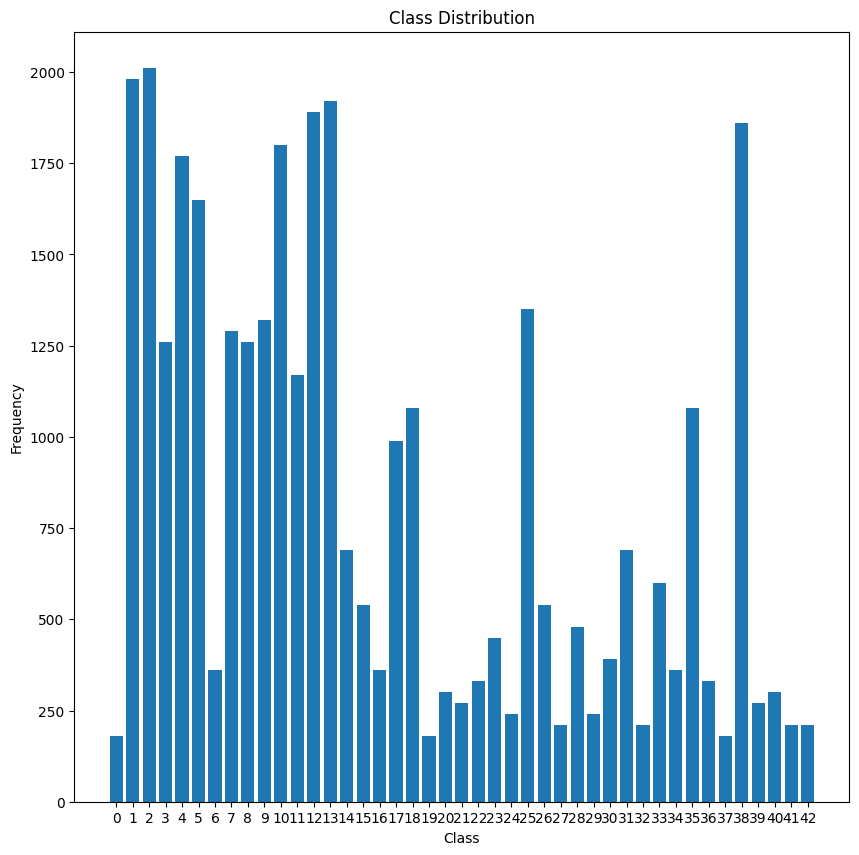

In [22]:

# Create a bar plot
plt.figure(figsize=(10, 10))
plt.bar(unique, counts, tick_label=unique)

# Add labels and title

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')

# Show the plot


# Modelo LeNet
El Modelo LeNet es el pionero de las redes neuronales convolucionales, diseñada por Yann LeChun. Estan diseñadas para el análisis de imágenes y poder reconocerlas, especilamente de imágenes de 32x32 pixéles

## Arquitectura
- Capa de Input. El input cada modelo de LeNet utiliza una escala de grises para la imagén, donde cad auna es de tamaño 32*32.
- Primera capa Convolucional. Se aplican filtros convoluciones a las inputs. Esto es principalmente hecho para extraer esquinas, aristas y limitaciones de textura por la computación. Usualmente son 6.
- Primera capa de Pooling. La capa de Pooling hace más pequeña las dimensión de los mapas, para ayudar a hacer robusta la red neuronal.
- Segunda capa Convolucional. Más filtros se realizon después del primer pooling, y más grande los mapas previamente. analizando feautures a grandes rasgos en estos casos
- Segunda capa de Pooling. Sigue reduciendo más las imagenes y haciendo más robusta la red.
- Flattening: El resultado anterior se convierte un arreglo de una dimensión para poder analizar más.
- Hidden Connected Layers: Estas son similares a las redes neuronales normales, para analizar y después combinar feautres para tomar decisiones.
- Capa de Salida: La capa final hace las preddiciones finales, basandose en las clases disponibles. 

## Definición de Funciones
- Convolución. Se utiliza un filtro, o kernel, para la entrada, donde se utiliza una multiplicación para cada elemento y entradas, por ejemplo en una imagén, los pixles alreadedor de un pixel. Esto permite a la red detectar caractesticas como bordes o texturas para la red.

- Pooling. Esta sirve para reducir las dimensiones las caracterisitcas, al mismo tiempo guardando la información imporante. Ayuda a reducir la complejidad de la red y la invarianza también, ya que es menos factible que cambie por detalles, como los números por ejemplo. En otras paalabras, ayuda a evitar overfitting. 

- Función de Activación. Operación apliacada para cada elemento en la salidad de una neurona. Ayuda para poder aprender a la neurona debido a su no linealidad. En otras palabras, ayuda a decir si se activa una neurona o no. 

In [23]:
model = Sequential()
    
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(classes, activation='softmax'))

In [24]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
total_samples = loaded_data["labels"].shape[0]
class_weights = np.array([total_samples / count for count in class_frequencies.values()])
class_weights = tf.constant(class_weights, dtype=tf.float32)

def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.gather(class_weights, y_true)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    weighted_loss = unweighted_loss * weights
    return weighted_loss
model.compile(optimizer=optimizer, loss=weighted_categorical_crossentropy, metrics=['accuracy'])

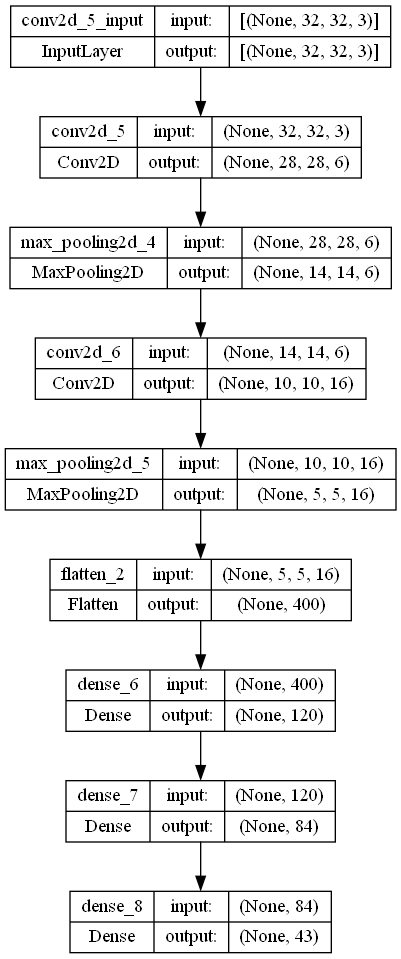

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file = 'grafica_modelo.png', show_shapes = True, show_layer_names = True)